In [28]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

def preprocess(df, split_column, drop_first=True):
    '''
    Does the usual preprocessing steps on a pandas dataframe:
    1. Does one-hot encoding
    2. Standardizes the data
    3. Drop N/A
    4. Splits the data into x & y along split_column
    5. Returns (x, y)
    '''
    stds = StandardScaler().set_output(transform='pandas')
    df = stds.fit_transform(pd.get_dummies(df, drop_first=drop_first)).dropna()
    x = df.drop(split_column, axis=1)
    return (x, df[split_column][x.index])

def eliminate_outliers(X, y):
    '''Removes outliers using the IQR method'''
    Q1 = y.quantile(0.25)
    Q3 = y.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    non_outliers = (y >= lower_bound) & (y <= upper_bound)
    X = X[non_outliers]
    y = y[non_outliers]
    return (X, y)

def great_big_preprocessing_chain(df, split_column):
    '''Takes care of all the preprocessing stuff where it can get garbage collected'''
    df = df.drop('player_name', axis=1)
    df = df.drop('Unnamed: 0', axis=1)
    df = df.drop('team_rank', axis=1)
    df = df.drop('market_value_in_eur', axis=1)
    (X, y) = preprocess(df, split_column)
    (X, y) = eliminate_outliers(X, y)
    (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=42)
    pca = PCA()
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    return (X_train, X_test, y_train, y_test)

In [29]:
import numpy as np

In [30]:
X_train, X_test, y_train, y_test = great_big_preprocessing_chain(pd.read_csv('resources/2014_player_data_standardized.csv'), 'player_performance_valuation_standardized')


In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Define hyperparameter grid
param_grid = {
    'n_estimators': [1,2,3,4,5,10,20,30,40, 50],
    'max_depth': [1,2,3, 4],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# 2. Set up GridSearchCV
rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           cv=5,                # 5-fold cross-validation
                           scoring='r2',
                           n_jobs=-1,
                           return_train_score=True)

# 3. Fit on training data
grid_search.fit(X_train, y_train)

# 4. Evaluate on the test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# 5. Print metrics
print("Best Parameters:", grid_search.best_params_)
print("Train R²:", best_rf.score(X_train, y_train))
print("Test R²:", best_rf.score(X_test, y_test))
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test MAE:", mean_absolute_error(y_test, y_pred))


Best Parameters: {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Train R²: 0.4147680062906751
Test R²: 0.03629060826695096
Test MSE: 0.05665972337615124
Test MAE: 0.17891376136131262


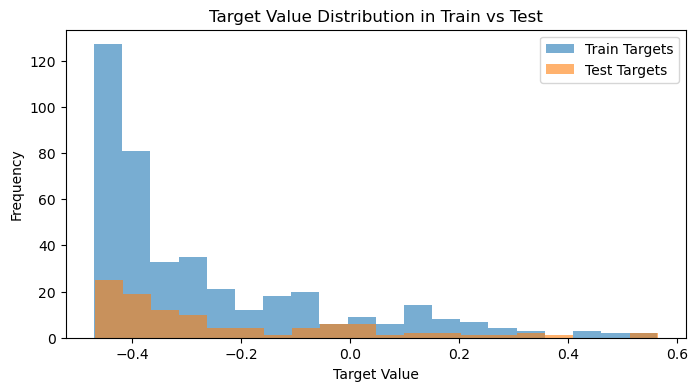

In [32]:
# Plot y_train vs y_test distribution
plt.figure(figsize=(8, 4))
plt.hist(y_train, bins=20, alpha=0.6, label='Train Targets')
plt.hist(y_test, bins=20, alpha=0.6, label='Test Targets')
plt.legend()
plt.title('Target Value Distribution in Train vs Test')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.show()


In [33]:
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(f"{params} --> mean CV R²: {mean_score:.4f}")


{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1} --> mean CV R²: -0.0775
{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2} --> mean CV R²: -0.0703
{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 3} --> mean CV R²: -0.0557
{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 4} --> mean CV R²: -0.0426
{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5} --> mean CV R²: -0.0357
{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10} --> mean CV R²: -0.0182
{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20} --> mean CV R²: -0.0087
{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30} --> mean CV R²: -0.0054
{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40} --> mean CV R²: -0.0068
{'max_depth': 1, 'min_samples_lea

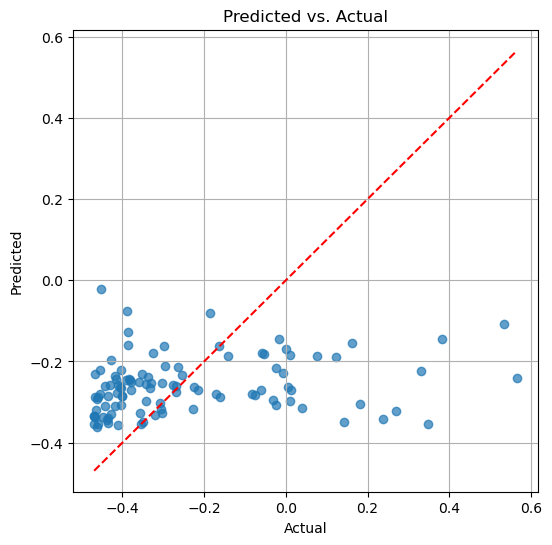

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs. Actual")
plt.grid(True)
plt.show()


In [35]:
import numpy as np
print("Variance in y_test:", np.var(y_test))

Variance in y_test: 0.05879337055568116


In [36]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [20, 50, 100],
}

gb_model = HistGradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb_model, param_grid, scoring='r2', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_gb = grid_search.best_estimator_
y_pred = best_gb.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("Test R²:", best_gb.score(X_test, y_test))
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test MAE:", mean_absolute_error(y_test, y_pred))


NameError: name 'HistGradientBoostingRegressor' is not defined

In [37]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42, n_estimators=100, max_depth=4, learning_rate=0.1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print("XGB Test R²:", r2_score(y_test, y_pred))

XGB Test R²: -0.046113195971225096
